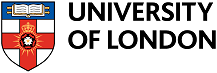

## CM3070 Final Project

### Final Prototype

`Student ID         : 210223512    `<br>
`Date of Submission : 27 March 2023`<br>

In [1]:
# import libraries
import os
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# import libraries
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.impute import KNNImputer
from keras.callbacks import EarlyStopping
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# store the data as a dataframe in the variable df
df = pd.read_csv('dataset.csv')

In [4]:
# display the first five rows of the dataframe
df.head()

,year,state,white_population_pct,african_american_population_pct,asian_population_pct,hispanic_population_pct,university_graduates,unemployment_rate,poverty_rate,median_age,median_household_income,cook_partisan_voting_index,democratic_votes,republican_votes,midterm_election,winner
0,2002,Alabama,NaN,NaN,NaN,NaN,0.227,0.059,0.154,NaN,35943,NaN,538878,792561,Yes,Republican
1,2002,Alaska,NaN,NaN,NaN,NaN,0.256,0.073,0.093,NaN,51844,NaN,24133,179438,Yes,Republican
2,2002,Arkansas,NaN,NaN,NaN,NaN,0.183,0.055,0.163,NaN,32819,NaN,433386,370735,Yes,Democratic
3,2002,Colorado,NaN,NaN,NaN,NaN,0.357,0.055,0.095,NaN,48060,NaN,648130,717893,Yes,Republican
4,2002,Delaware,NaN,NaN,NaN,NaN,0.295,0.040,0.093,NaN,48096,NaN,135253,94793,Yes,Democratic


In [5]:
# define a method to create time-shifted features
def create_time_shifted_features(data):
    
    old_data = {}
    new_data = pd.DataFrame()
    
    for state in data['state'].unique():
        old_data[state] = data[data['state'] == state].sort_values(by = ['year'])
     
    for state, df in old_data.items():
        previous = df.shift(1)
        previous.columns = ['previous_' + column for column in previous.columns]
        df.columns = ['current_' + column for column in df.columns]
        concat = pd.concat([df, previous], axis = 1).iloc[1:]
        
        if len(new_data) > 0:
            new_data = pd.concat([new_data, concat], axis = 0)
        else:
            new_data = concat
            
    return new_data

In [6]:
# creates time-shifted features using the data
df = create_time_shifted_features(df)

In [7]:
# display the first five rows of the dataframe
df.head()

,current_year,current_state,current_white_population_pct,current_african_american_population_pct,current_asian_population_pct,current_hispanic_population_pct,current_university_graduates,current_unemployment_rate,current_poverty_rate,current_median_age,...,previous_university_graduates,previous_unemployment_rate,previous_poverty_rate,previous_median_age,previous_median_household_income,previous_cook_partisan_voting_index,previous_democratic_votes,previous_republican_votes,previous_midterm_election,previous_winner
29,2004,Alabama,NaN,NaN,NaN,NaN,0.223,0.057,0.161,NaN,...,0.227,0.059,0.154,NaN,35943.0,NaN,538878.0,792561.0,Yes,Republican
93,2008,Alabama,NaN,NaN,NaN,NaN,0.220,0.057,0.159,NaN,...,0.223,0.057,0.161,NaN,37062.0,NaN,595018.0,1242200.0,No,Republican
125,2010,Alabama,0.707,0.270,0.014,0.038,0.219,0.105,0.189,37.8,...,0.220,0.057,0.159,NaN,42586.0,8.0,752391.0,1305383.0,No,Republican
220,2016,Alabama,0.732,0.053,0.076,0.067,0.247,0.058,0.172,39.0,...,0.219,0.105,0.189,37.8,40538.0,13.0,515619.0,968181.0,Yes,Republican
283,2020,Alabama,0.803,0.165,0.016,0.069,0.278,0.064,0.149,39.2,...,0.247,0.058,0.172,39.0,46309.0,14.0,748709.0,1335104.0,No,Republican


In [8]:
# display the columns of the dataframe
df.columns

Index(['current_year', 'current_state', 'current_white_population_pct',
       'current_african_american_population_pct',
       'current_asian_population_pct', 'current_hispanic_population_pct',
       'current_university_graduates', 'current_unemployment_rate',
       'current_poverty_rate', 'current_median_age',
       'current_median_household_income', 'current_cook_partisan_voting_index',
       'current_democratic_votes', 'current_republican_votes',
       'current_midterm_election', 'current_winner', 'previous_year',
       'previous_state', 'previous_white_population_pct',
       'previous_african_american_population_pct',
       'previous_asian_population_pct', 'previous_hispanic_population_pct',
       'previous_university_graduates', 'previous_unemployment_rate',
       'previous_poverty_rate', 'previous_median_age',
       'previous_median_household_income',
       'previous_cook_partisan_voting_index', 'previous_democratic_votes',
       'previous_republican_votes', 'previ

In [9]:
# numerical variables
NUMERICAL_VARIABLES = ['current_year',
                       'current_white_population_pct',
                       'current_african_american_population_pct',
                       'current_asian_population_pct',
                       'current_hispanic_population_pct',
                       'current_university_graduates',
                       'current_unemployment_rate',
                       'current_poverty_rate',
                       'current_median_age',
                       'current_median_household_income',
                       'current_cook_partisan_voting_index',
                       'current_democratic_votes',
                       'current_republican_votes',
                       'previous_year',
                       'previous_white_population_pct',
                       'previous_african_american_population_pct',
                       'previous_asian_population_pct',
                       'previous_hispanic_population_pct',
                       'previous_university_graduates',
                       'previous_unemployment_rate',
                       'previous_poverty_rate',
                       'previous_median_age',
                       'previous_median_household_income',
                       'previous_cook_partisan_voting_index',
                       'previous_democratic_votes',
                       'previous_republican_votes']

In [10]:
# categorical variables
CATEGORICAL_VARIABLES = ['previous_midterm_election',
                         'previous_winner',
                         'current_midterm_election']

In [11]:
# target variables
TARGET_VARIABLE = 'current_winner'

In [12]:
# store the features and target in the variables X and y
X, y = df[NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES], df[TARGET_VARIABLE]

In [13]:
# split X and y into training and test sets in the ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
# impute missing values in the numerical variables using KNNImputer
N_train = KNNImputer(n_neighbors = 5).fit_transform(X_train[NUMERICAL_VARIABLES])
N_test = KNNImputer(n_neighbors = 5).fit_transform(X_test[NUMERICAL_VARIABLES])

In [15]:
# impute missing values in the categorical variables with the word 'unknown'
C_train, C_test = X_train[CATEGORICAL_VARIABLES].fillna('Unknown'), X_test[CATEGORICAL_VARIABLES].fillna('Unknown')

In [16]:
# combine both imputed arrays to form X_train and X_test
X_train = pd.DataFrame(data = np.hstack((N_train, C_train)), columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)
X_test = pd.DataFrame(data = np.hstack((N_test, C_test)), columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)

In [17]:
# initialize OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer([('one-hot-encoder', OneHotEncoder(handle_unknown = 'ignore'), CATEGORICAL_VARIABLES),
                                  ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

In [18]:
# preprocess X_train and X_test
X_train, X_test = preprocessor.fit_transform(X_train), preprocessor.fit_transform(X_test)

In [19]:
# initialize LabelEncoder to convert y_train and y_test
y_train, y_test = LabelEncoder().fit_transform(y_train), LabelEncoder().fit_transform(y_test)

In [20]:
# split X_train and y_train further into training and validation sets
# the ratio of training, validation and test sets is 60:20:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [21]:
# compute the samples
samples = df.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()

In [22]:
# print the samples
print('Samples: {}'.format(samples))

Samples: current_winner
Democratic    144
Republican    149
Name: current_winner, dtype: int64


In [23]:
# compute the baseline
baseline = samples.iloc[1] / samples.sum()

In [24]:
# print the baseline
print('Baseline: {:.2f}'.format(baseline))

Baseline: 0.51


In [25]:
# print the balanced accuracy score
balanced_accuracy_score(y_train, np.zeros(len(y_train)))

0.5

In [26]:
# define a method to create a model
def create_model(activation, input_dimensions, output_dimensions, optimizer, loss, metrics):
    
    model = Sequential()
    model.add(Dense(output_dimensions, activation = activation, input_shape = (input_dimensions, )))
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    
    return model

In [27]:
# define a method to train a model
def train_model(model, X, y, class_weight, batch_size, epochs, val_data, callbacks):
    
    X_train, X_val, y_train, y_val = X, val_data[0], y, val_data[1]
    history = model.fit(X_train, y_train, class_weight = class_weight, batch_size = batch_size, epochs = epochs,
                        validation_data = (X_val, y_val), callbacks = callbacks, verbose = 0)
    
    return {'model': model, 'evaluation': model.evaluate(X_val, y_val, verbose = 0)[1:], 'history': history}

In [28]:
# creates a model
model = create_model(activation = 'sigmoid',
                     input_dimensions = X_train.shape[1],
                     output_dimensions = 1,
                     optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['categorical_accuracy',
                                tf.keras.metrics.Precision(name = 'precision'),
                                tf.keras.metrics.Recall(name = 'recall'),
                                tf.keras.metrics.AUC(name = 'auc', multi_label = True)])

In [29]:
# prints a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [30]:
# trains the model
trained_model = train_model(model, X_train, y_train,
                            class_weight = dict(enumerate(compute_class_weight('balanced',
                                                                               classes = np.unique(y_test),
                                                                               y = y_train))),
                            batch_size = 30,
                            epochs = 200,
                            val_data = (X_val, y_val),
                            callbacks = [EarlyStopping(monitor = 'val_loss',
                                                       restore_best_weights = True,
                                                       patience = 5,
                                                       verbose = 0)])

In [31]:
# print the metrics of the model
print('Accuracy (Validation): {:.2f} (Baseline: {:.2f})'.format(trained_model['evaluation'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_model['evaluation'][1]))
print('Recall (Validation): {:.2f}'.format(trained_model['evaluation'][2]))
print('AUC (Valiation): {:.2f}'.format(trained_model['evaluation'][3]))

Accuracy (Validation): 1.00 (Baseline: 0.51)
Precision (Validation): 0.89
Recall (Validation): 0.93
AUC (Valiation): 0.94


In [32]:
# predict the validation set using the model
predictions = (trained_model['model'].predict(X_val, verbose = 0) > 0.5).astype('int32')

In [33]:
# print the balanced accuracy score for predictions on validation set
print('Balanced Accuracy (Validation): {:.2f} (Baseline: {:.2f})'.format(balanced_accuracy_score(y_val, predictions), baseline))

Balanced Accuracy (Validation): 0.89 (Baseline: 0.51)


In [34]:
# define a method to plot the training and validation curves for the model
def plot_curves(history, monitors):
    
    fig, axs = plt.subplots(1, 2, sharex = 'all', figsize = (20, 5))
    
    for ax, monitor in zip(axs.flat, monitors):
        train, val = history.history[monitor], history.history['val_' + monitor]
        epochs = range(1, len(train) + 1)
        
        if monitor == 'loss':
            monitor = monitor.capitalize()
            
        else:
            monitor = monitor.upper()
            
        ax.plot(epochs, train, 'b.', label = 'Training ' + monitor)
        ax.plot(epochs, val, 'r.', label = 'Validation ' + monitor)
        ax.set_xlim([0, len(train)])
        ax.title.set_text('Training and Validation ' + monitor)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend(prop = {'size': 12})
        ax.grid()
        
    plt.tight_layout()
    plt.show()

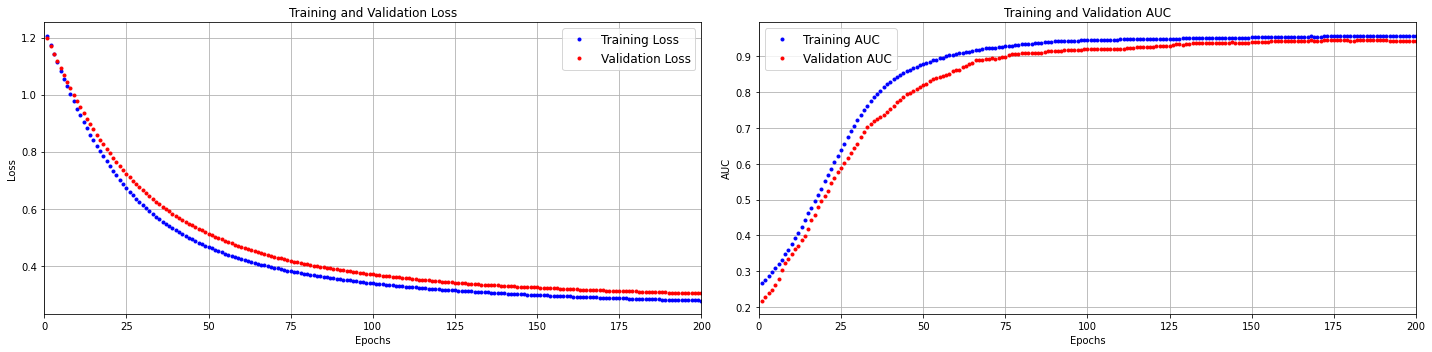

In [35]:
# plot the training and validation curves for the model
plot_curves(trained_model['history'], monitors = ['loss', 'auc'])

In [36]:
# predict the test set using the model
y_pred = (trained_model['model'].predict(X_test, verbose = 0) > 0.5).astype('int32')

In [37]:
# print the balanced accuracy score for predictions on test set
print('Balanced Accuracy (Test): {:.2f} (Baseline: {:.2f})'.format(balanced_accuracy_score(y_test, y_pred), baseline))

Balanced Accuracy (Test): 0.87 (Baseline: 0.51)
